In [ ]:
pip install pandas scikit-learn matplotlib

In [ ]:
pip install imbalanced-learn

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [179]:
rutafin = 'C:/Users/omarc/OneDrive/Escritorio/Proyectos VSC/OmarCano/Track Analítico UNI/05_Datos/03_Datos_Finales'

tablon_final_df = pd.read_csv(f'{rutafin}/tablon_final_df.csv')
df_modelo = tablon_final_df[tablon_final_df['FLG_ESTUDIANTE'] == 1].copy()

In [180]:
# Imputación de valores nulos
df_modelo['DOMICILIO_DEPA'] = df_modelo['DOMICILIO_DEPA'].fillna('DESCONOCIDO').astype(str).str.upper()
df_modelo['NACIMIENTO_DEPA'] = df_modelo['NACIMIENTO_DEPA'].replace('0', 'DESCONOCIDO').astype(str).str.upper()
df_modelo['NACIMIENTO_PAIS'] = df_modelo['NACIMIENTO_PAIS'].replace('0', 'DESCONOCIDO').astype(str).str.upper()
df_modelo['COLEGIO_PAIS'] = df_modelo['COLEGIO_PAIS'].replace('0', 'DESCONOCIDO').astype(str).str.upper()
df_modelo['COLEGIO_DEPA'] = df_modelo['COLEGIO_DEPA'].replace('0', 'DESCONOCIDO').astype(str).str.upper()

In [181]:
# Agrupación de departamentos por macroregión
lima = ['LIMA']
callao = ['CALLAO']
costa = ['PIURA', 'TUMBES','LAMBAYEQUE','LA LIBERTAD','ÁNCASH','ANCASH','ICA','MOQUEGUA', 'AREQUIPA','TACNA']
sierra = ['CAJAMARCA','HUÁNUCO','HUANUCO','PASCO', 'JUNIN', 'JUNÍN', 'HUANCAVELICA', 'AYACUCHO','APURIMAC','APURÍMAC', 
          'CUSCO', 'PUNO']
selva = ['AMAZONAS', 'SAN MARTÍN', 'UCAYALI', 'MADRE DE DIOS', 'LORETO']

def clasificar_macroregion(depa):
    if depa in lima:
        return 'Lima'
    elif depa in callao:
        return 'Callao'
    elif depa in costa:
        return 'Costa'
    elif depa in sierra:
        return 'Sierra'
    elif depa in selva:
        return 'Selva'
    else:
        return 'Desconocido'

df_modelo['DOMICILIO_MACROREGION'] = df_modelo['DOMICILIO_DEPA'].apply(clasificar_macroregion)
df_modelo['NACIMIENTO_MACROREGION'] = df_modelo['NACIMIENTO_DEPA'].apply(clasificar_macroregion)
df_modelo['COLEGIO_MACROREGION'] = df_modelo['COLEGIO_DEPA'].apply(clasificar_macroregion)

In [182]:
# Agrupación de países
peru = ['PERÚ','PERU']
extranjero = ['ARGENTINA','VENEZUELA','JAPON','COREA REPUBLICA','ITALIA','ESTADOS UNIDOS','BRASIL','SUIZA','COLOMBIA','RSS DE UCRANIA',
              'PARAGUAY','CHILE','FRANCIA','NUEVA ZELANDA','BOLIVIA','RUSIA','GUATEMALA','ALEMANIA','ESPAÑA']

def clasificar_pais(pais):
    if pais in peru:
        return 'Perú'
    elif pais in extranjero:
        return 'Extranjero'
    else:
        return 'Desconocido'

# Aplicar la función a las columnas de país
df_modelo['NACIMIENTO_PAIS'] = df_modelo['NACIMIENTO_PAIS'].apply(clasificar_pais)
df_modelo['COLEGIO_PAIS'] = df_modelo['COLEGIO_PAIS'].apply(clasificar_pais)

In [183]:
# 4. Codificación de variables categóricas
categorical_features = [
    'MODALIDAD_AGRUP', 'DOMICILIO_MACROREGION', 'NACIMIENTO_MACROREGION', 'COLEGIO_MACROREGION', 
    'NACIMIENTO_PAIS', 'COLEGIO_PAIS'
]#'DETALLE'
numeric_features = [
    'CICLO_RELATIVO','EDAD','EDAD_FIN_COLEGIO','EDAD_INICIO_UNI','FLG_CAMBIO_CARRERA',
    'MIN_CALIF_ADMIS','MAX_CALIF_ADMIS','PROM_CALIF_ADMIS', 'CANT_ADMIS', 
    'MIN_CALIF_CEPRE', 'MAX_CALIF_CEPRE','PROM_CALIF_CEPRE', 'CANT_CEPRE'
]#'FLG_ESTUDIANTE','MAX_CODYEAR','CODYEAR','MIN_CODYEAR','TOTAL_RECORDS','MAX_CICLORELATIVO',

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes
            ('scaler', StandardScaler())  # Escalar características numéricas
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Codificar características categóricas
        ]), categorical_features)
    ]
)

In [187]:
# Preparar las variables para el modelo
X = df_modelo[numeric_features + categorical_features]
y = df_modelo['DESERCIÓN']  # Suponiendo que 'DESERCIÓN' es la columna objetivo

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Crear el pipeline con RandomForestClassifier y manejar el desbalance con SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Aplicar SMOTE después del preprocesamiento
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 5. Definir el rango de hiperparámetros para la búsqueda
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': [None, 'sqrt']
}

# 6. Realizar GridSearch para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # Número de particiones para cross-validation
    scoring='f1',
    n_jobs=-1
)

In [188]:
# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)
print(f"Mejores parámetros: {grid_search.best_params_}")

# 6. Evaluar el modelo
y_pred = grid_search.predict(X_test)

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# 7. Evaluar el modelo con curvas ROC
y_probs = grid_search.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

Mejores parámetros: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Matriz de confusión:
[[49451  3835]
 [ 1327  3104]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     53286
           1       0.45      0.70      0.55      4431

    accuracy                           0.91     57717
   macro avg       0.71      0.81      0.75     57717
weighted avg       0.93      0.91      0.92     57717



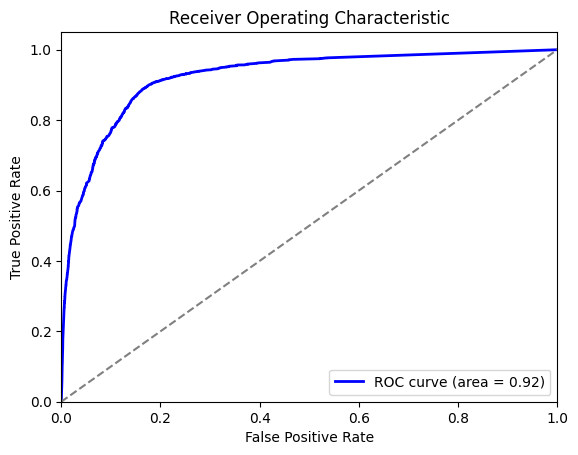

In [196]:
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
##################################################################

In [190]:
# 5. Preparar las variables para el modelo
X = df_modelo[numeric_features + categorical_features]
y = df_modelo['DESERCIÓN']  # Suponiendo que 'DESERCIÓN' es la columna objetivo

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo y pipeline
modelo_arbol = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42))
])

In [191]:
# Entrenar el modelo
modelo_arbol.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CICLO_RELATIVO', 'EDAD',
                                                   'EDAD_FIN_COLEGIO',
                                                   'EDAD_INICIO_UNI',
                                                   'FLG_CAMBIO_CARRERA',
                                                   'MIN_CALIF_ADMIS',
                                                   'MAX_CALIF_ADMIS',
                                                   'PROM_CALIF_ADMIS',
                                                   'CANT_ADMIS',
                                                   'MIN_CALIF_CEPRE',
                                                   'MAX_CALIF_CEPRE',
                                                   'PROM_CALIF_CEPRE'...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['MODALIDAD_AGRUP',
                                                   'DOMICILIO_MACROREGION',
                                                   'NACIMIENTO_MACROREGION',
                                                   'COLEGIO_MACROREGION',
                                                   'NACIMIENTO_PAIS',
                                                   'COLEGIO_PAIS'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=42))])

In [192]:
# Obtener las predicciones del modelo
y_pred = modelo_arbol.predict(X_test)

In [193]:
# Evaluación del modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Matriz de confusión:
[[52940   346]
 [ 3870   561]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     53286
           1       0.62      0.13      0.21      4431

    accuracy                           0.93     57717
   macro avg       0.78      0.56      0.59     57717
weighted avg       0.91      0.93      0.90     57717



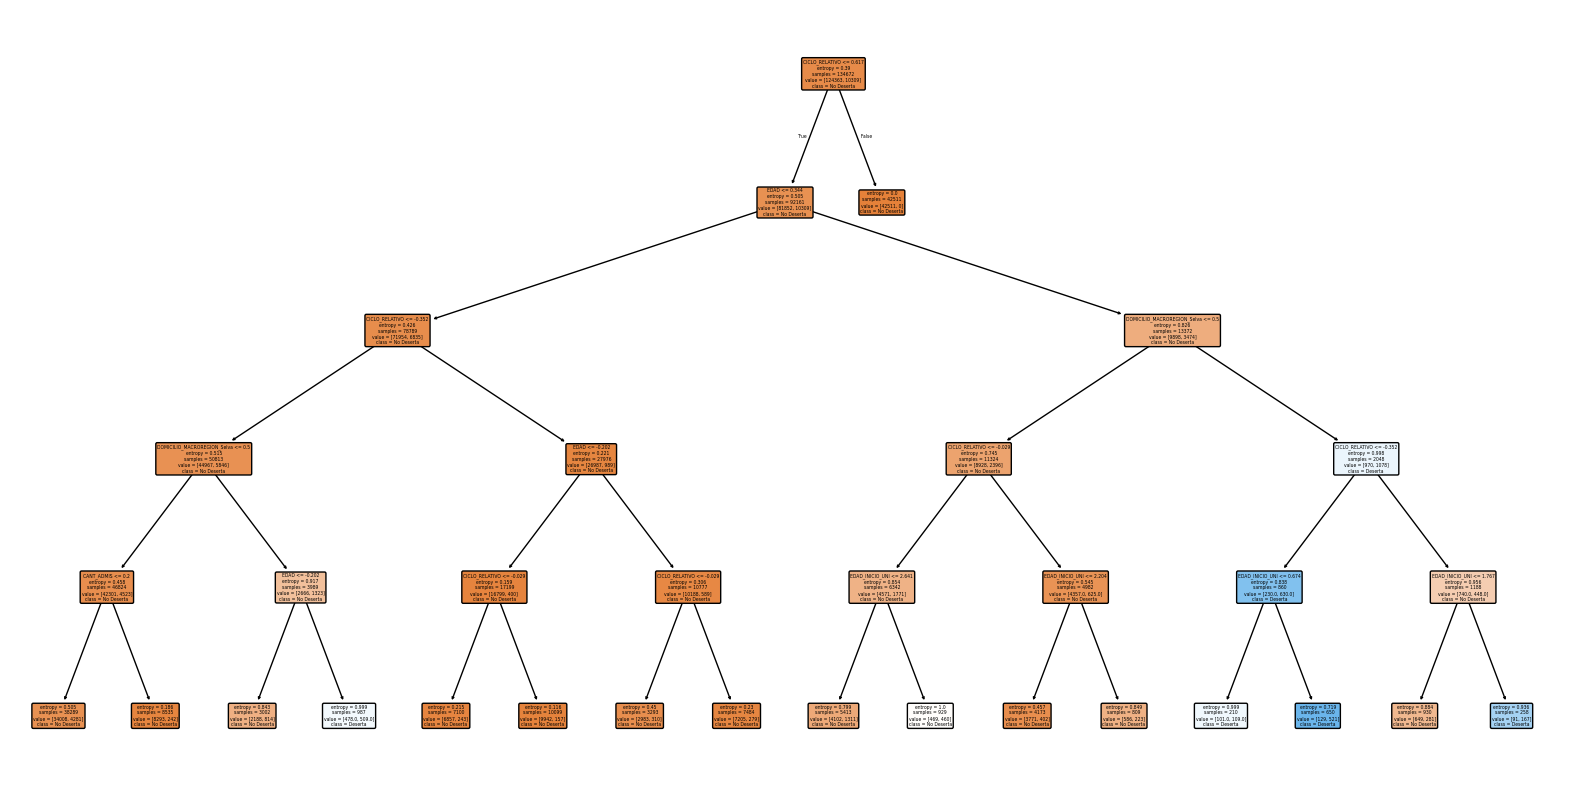

In [194]:
# Visualización del árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(modelo_arbol.named_steps['classifier'],  # Extraer el clasificador del pipeline
         feature_names=modelo_arbol.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist() + 
                        modelo_arbol.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist(),
         class_names=['No Deserta', 'Deserta'],
         filled=True, rounded=True)
plt.show()

In [195]:
# Interpretación de los resultados
importances = pd.Series(modelo_arbol.named_steps['classifier'].feature_importances_,
                       index=modelo_arbol.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist() + 
                             modelo_arbol.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()).sort_values(ascending=False)
print("\nImportancia de las características:")
print(importances)


Importancia de las características:
CICLO_RELATIVO                                 0.615565
EDAD                                           0.181503
DOMICILIO_MACROREGION_Selva                    0.130178
CANT_ADMIS                                     0.040842
EDAD_INICIO_UNI                                0.031912
NACIMIENTO_PAIS_Perú                           0.000000
NACIMIENTO_MACROREGION_Lima                    0.000000
DOMICILIO_MACROREGION_Costa                    0.000000
DOMICILIO_MACROREGION_Desconocido              0.000000
DOMICILIO_MACROREGION_Lima                     0.000000
DOMICILIO_MACROREGION_Sierra                   0.000000
NACIMIENTO_MACROREGION_Costa                   0.000000
NACIMIENTO_MACROREGION_Desconocido             0.000000
NACIMIENTO_MACROREGION_Selva                   0.000000
MODALIDAD_AGRUP_Victimas del Terrorismo        0.000000
COLEGIO_MACROREGION_Costa                      0.000000
COLEGIO_MACROREGION_Desconocido                0.000000
COLEGIO_MAC